In [1]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from formulae import design_matrices

sns.set()

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

In [3]:
games = pd.read_parquet(Path("../data/iowa_games.parquet"))

In [4]:
games.describe()

,id,season,week,attendance,venue_id,home_id,home_points,home_post_win_prob,home_pregame_elo,home_postgame_elo,away_id,away_points,away_post_win_prob,away_pregame_elo,away_postgame_elo,excitement_index
count,8.100000e+01,81.000000,81.000000,72.000000,81.000000,81.000000,74.000000,74.000000,80.000000,73.000000,81.000000,74.000000,74.000000,79.000000,72.000000,74.000000
mean,4.012164e+08,2020.012346,7.604938,59169.805556,3672.641975,1488.641975,23.000000,0.615929,1703.037500,1719.890411,1412.802469,19.283784,0.384071,1667.177215,1671.305556,4.654558
std,1.995202e+05,2.052400,4.088640,24701.039025,826.382059,1047.931228,12.334382,0.397101,169.892553,181.787083,1086.824128,13.615584,0.397101,199.615962,212.192023,2.378032
min,4.009345e+08,2017.000000,1.000000,771.000000,347.000000,66.000000,0.000000,0.000813,1243.000000,1125.000000,36.000000,0.000000,0.000007,1208.000000,1208.000000,0.369269
25%,4.010129e+08,2018.000000,4.000000,57027.500000,3793.000000,194.000000,14.000000,0.137716,1627.750000,1629.000000,164.000000,10.000000,0.014253,1508.000000,1489.000000,2.793962
50%,4.012473e+08,2020.000000,8.000000,66838.000000,3793.000000,2294.000000,23.000000,0.789722,1704.000000,1736.000000,2294.000000,17.500000,0.210278,1660.000000,1689.000000,4.278054
75%,4.014051e+08,2022.000000,11.000000,69250.000000,3830.000000,2294.000000,30.750000,0.985747,1810.000000,1842.000000,2294.000000,24.000000,0.862284,1829.000000,1832.500000,6.785197
max,4.015204e+08,2023.000000,15.000000,111519.000000,6577.000000,2509.000000,55.000000,0.999993,2165.000000,2233.000000,2751.000000,63.000000,0.999187,2161.000000,2065.000000,9.477399


In [5]:
def get_iowa_points(game):
    if game.away_team == "Iowa":
        return game.away_points
    else:
        return game.home_points


iowa_points = games.apply(get_iowa_points, axis="columns").dropna()
games["Iowa_points"] = iowa_points
games["Home_game"] = games["home_team"] == "Iowa"
games["Years_since_2017"] = games["season"] - 2017

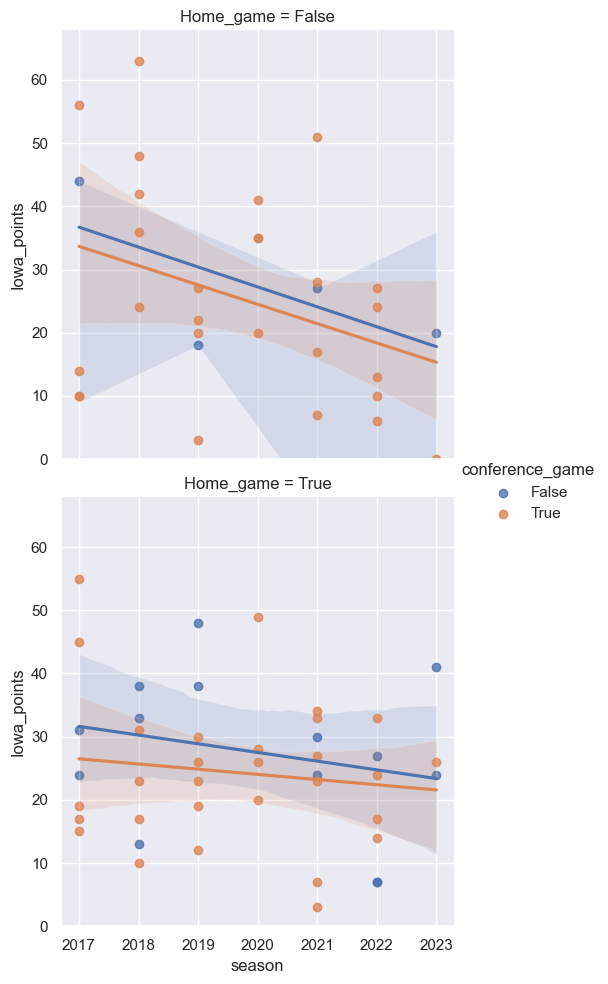

In [6]:
g = sns.lmplot(
    games,
    x="season",
    y="Iowa_points",
    hue="conference_game",
    row="Home_game",
)
g.set(ylim=(0, None))

In [7]:
games.pivot_table(
    "Iowa_points",
    "conference_game",
    "Home_game",
)

Home_game,False,True
conference_game,,
False,27.250000,27.500000
True,25.518519,24.344828


# Bayesian mixed-effects model

Let's predict scoring from 2019 on...

Let's modify [this pymc tutorial](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-poisson-regression.html) for the analysis.


In [8]:
design_matrix = design_matrices(
    "Iowa_points ~ conference_game * Home_game",
    games.query("season>2018"),
)
exogenous = design_matrix.common.as_dataframe()
endogenous = design_matrix.response.as_dataframe()

Automatically removing 7/57 rows from the dataset.


In [9]:
with pm.Model() as model:
    # define priors, weakly informative Normal
    b0 = pm.Normal("Intercept", mu=26, sigma=10)
    b1 = pm.Normal("conference_game", mu=0, sigma=10)
    b2 = pm.Normal("Home_game", mu=0, sigma=10)
    b3 = pm.Normal("conference_game:Home_game", mu=0, sigma=10)

    # define linear model and link function
    theta = (
        b0
        + b1 * exogenous["conference_game"].values
        + b2 * exogenous["Home_game"].values
        + b3 * exogenous["conference_game:Home_game"].values
    )

    # Define Poisson likelihood
    y = pm.Poisson(
        "y", mu=pm.math.exp(theta), observed=endogenous["Iowa_points"].values
    )

    # sample
    points = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, conference_game, Home_game, conference_game:Home_game]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


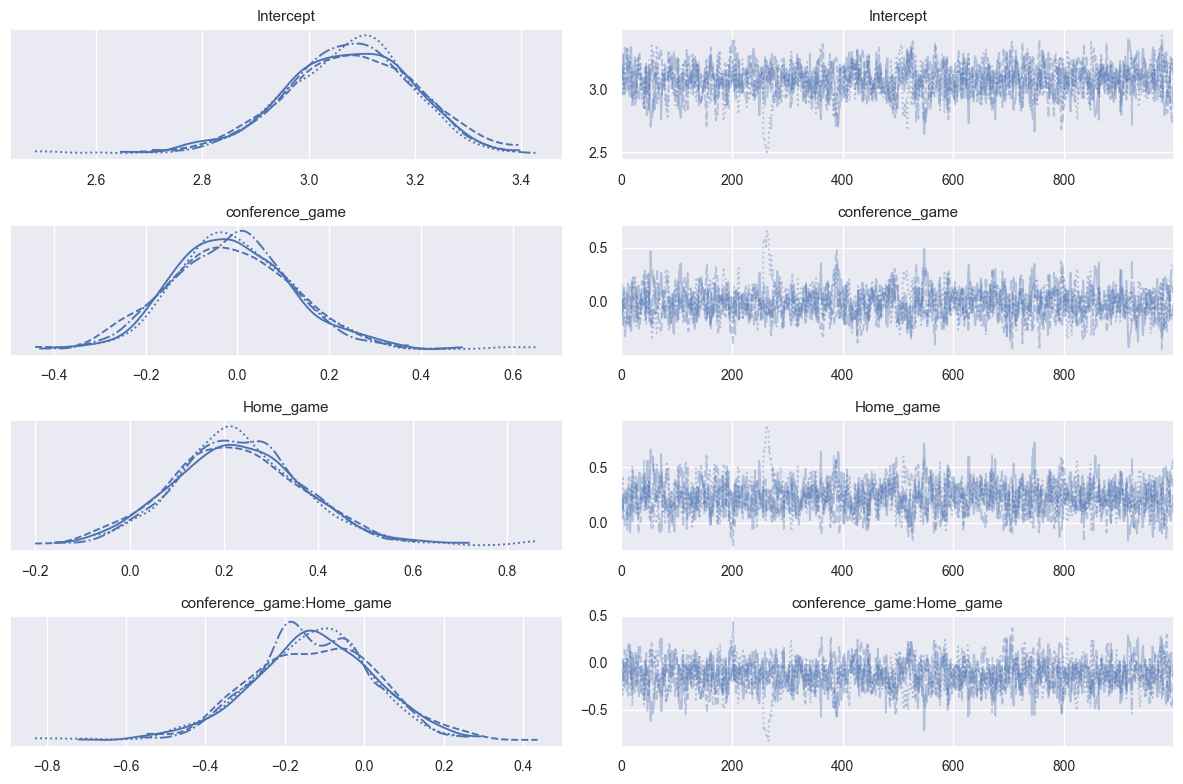

In [10]:
az.plot_trace(points)
plt.tight_layout()

Okay, back in cartesian space, what's the average scoring?


In [11]:
az.summary(np.exp(points.posterior["Intercept"]), kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,21.79,2.622,16.77,26.615


Now, given 8 games left (including the bowl), these being conference games, and 4 of them being at home, what is the chance of Brian getting to stay?

First, he's got to score how much to stay?


In [12]:
points_to_stay = 325
games_left = 8
home_games_left = 4
points_scored_in_2023 = games.loc[games.season == 2023, "Iowa_points"].sum()
points_per_game_to_stay = (points_to_stay - points_scored_in_2023) / 8
print(f"Score {points_per_game_to_stay} to stay")

Score 26.75 to stay


In [13]:
p = points.posterior

posterior_2023_points = np.exp(
    (
        p["Intercept"]
        + p["conference_game"]
        + (home_games_left / games_left) * p["Home_game"]
    ).data.ravel()
)
# plt.hist(posterior_2023_points, bins=np.arange(15, 35), cumulative=True, align="left")
# np.percentile(posterior_2023_points, 90)
print(
    "Chance of Brian staying:",
    np.mean(posterior_2023_points >= points_per_game_to_stay),
)

Chance of Brian staying: 0.1065


That's not good. Let's make a plot to look at the distribution


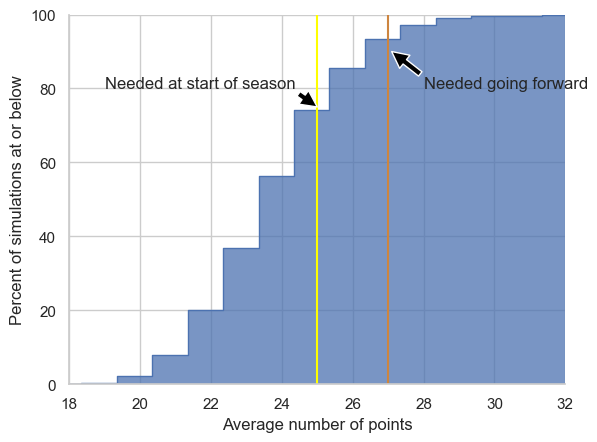

In [14]:
with sns.axes_style("whitegrid"):
    g = sns.histplot(
        posterior_2023_points,
        discrete=True,
        element="step",
        stat="percent",
        cumulative=True,
        fill=True,
    )
    g.set(
        xlim=(18, 32),
        ylim=(0, 100),
        ylabel="Percent of simulations at or below",
        xlabel="Average number of points",
    )
    g.vlines(27, 0, 100, color="peru")
    g.vlines(25, 0, 100, color="yellow")
    sns.despine()
    g.annotate(
        "Needed going forward",
        xy=(27.1, 90),
        xytext=(28, 80),
        arrowprops=dict(facecolor="black"),
    )
    g.annotate(
        "Needed at start of season",
        xy=(25, 75),
        xytext=(19, 80),
        arrowprops=dict(facecolor="black"),
    )

[(18.0, 34.0),
 Text(0, 0.5, 'Percent of simulations'),
 Text(0.5, 0, 'Average number of points Iowa scores')]

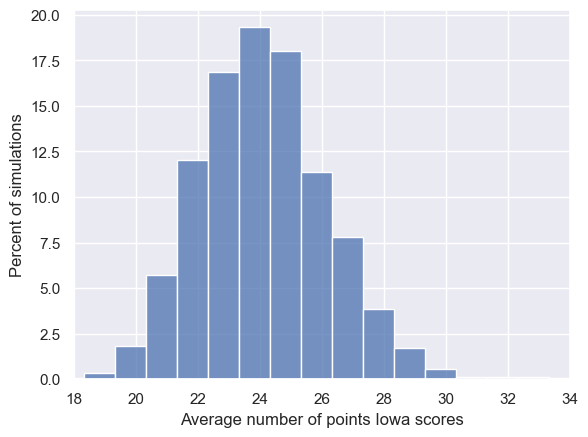

In [15]:
g = sns.histplot(
    posterior_2023_points,
    discrete=True,
    stat="percent",
    fill=True,
)
g.set(
    xlim=(18, 34),
    # ylim=(0, 100),
    ylabel="Percent of simulations",
    xlabel="Average number of points Iowa scores",
)